Deep Reinforcement Learning es un método derivado del algoritmo Q-Learning(método tabular).
Inspirado en el modelo desarrollado por Deep Mind en el paper "Playing Atari with Deep Reinforcement Learning" (https://arxiv.org/pdf/1312.5602.pdf).

Es modelo libre(model-free): No predice el estado siguiente.

Es sin política(off-policy): Usa la estrategia greedy para elegir los movimientos. Selecciona una acción aleatoria(para explorar nuevos caminos) con probabilidad ε, la cual va disminuyendo durante el entrenamiento.

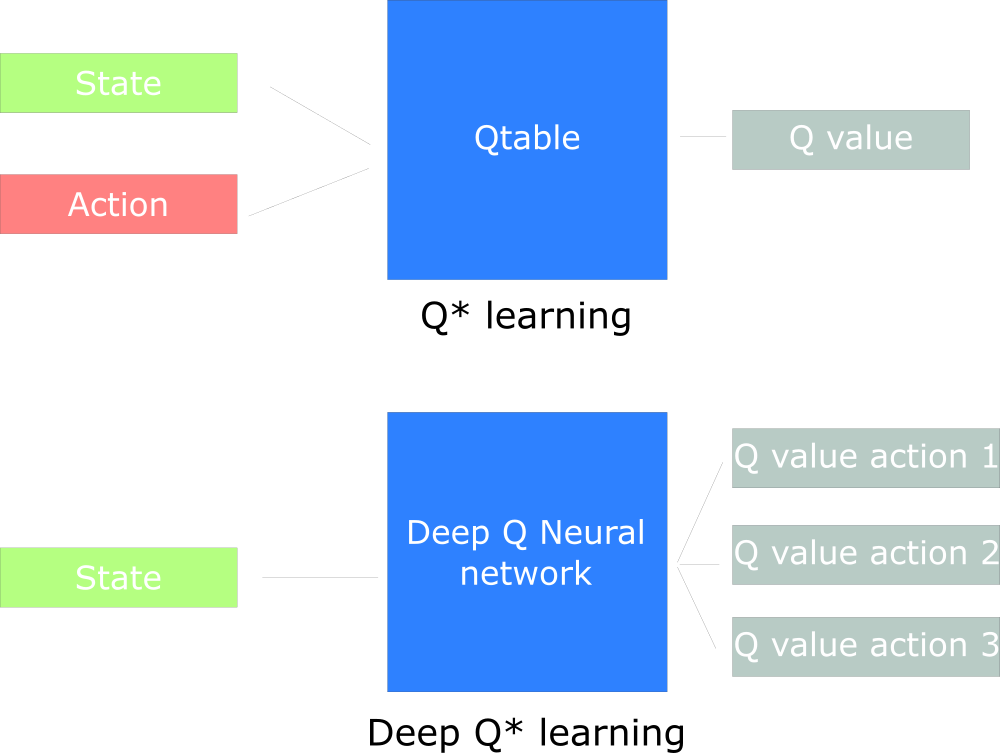

Imagen extraida de https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8

In [ ]:
import gym # https://gym.openai.com/
import numpy as np
import tensorflow as tf
import os

env = gym.make("MsPacman-v0")
obs = env.reset()

In [ ]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2] # crop and downsize
    img = img.sum(axis=2) # to greyscale
    img[img==mspacman_color] = 0 # Improve contrast
    img = (img // 3 - 128).astype(np.int8) # normalize from -128 to 127
    return img.reshape(88, 80, 1)

img = preprocess_observation(obs)

In [ ]:
input_height = 88
input_width = 80
input_channels = 1
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 520
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    X_state / 128.0
    with tf.variable_scope(name) as scope:
        prev_layer = tf.layers.conv2d(X_state, filters=40, kernel_size=8,
                                      strides = 4,
                                 padding='SAME',
                                 activation=tf.nn.relu, name="conv1")
        prev_layer = tf.layers.conv2d(prev_layer, filters=65, kernel_size=4,
                                      strides = 2,
                                    padding='SAME',
                                    activation=tf.nn.relu) 

        prev_layer = tf.layers.conv2d(prev_layer, filters=65, kernel_size=3,
                                    padding='SAME',strides = 1,activation=tf.nn.relu)
        last_conv_layer_flat = tf.layers.Flatten()(prev_layer)
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                  kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name

In [ ]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                            input_channels])
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
            for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

Descripción de la actualización de pesos mostrada en la celda de abajo(extraido de http://www.incompleteideas.net/book/RLbook2018.pdf).

próximos pesos = pesos+Ratio aprendizaje * (Proxima Recompensa+Ratio Descuento*max_Q - valor de la acción seleccionada) * gradiente

α -> Ratio de aprendizaje. Define la magnitud del cambio en los pesos.

γ -> Ratio de descuento. Ayuda a la convergencia del algoritmo.

maxq significa el máximo valor de la función q según la acción a.

El gradiente ∇ de una función es el vector de máximo crecimiento, por lo que el cambio de los pesos se orienta en la dirección de máximo cambio

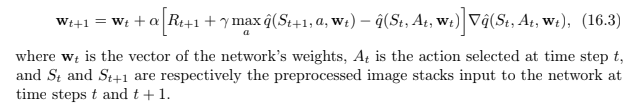

In [ ]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                            axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    clipped_error = tf.clip_by_value(error, 0.0, 1.0) #Valores<0 = 0, valores >1=1
    linear_error = 2 * (error - clipped_error)
    loss = tf.reduce_mean(tf.square(clipped_error) + linear_error) #Media de todos los errores

    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [ ]:
replay_memory_size = 400000
replay_memory = ReplayMemory(replay_memory_size)

In [ ]:
def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [ ]:
eps_min = 0.1
eps_max = 1.0
epsilon = eps_max
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # random action
    else:
        return np.argmax(q_values) # optimal action

In [ ]:
n_steps = 4000000  # total number of training steps
training_start = 10000  # start training after 10,000 game iterations
training_interval = 4  # run a training step every 4 game iterations
save_steps = 1000  # save the model every 1,000 training steps
copy_steps = 10000  # copy online DQN to target DQN every 10,000 training steps
discount_rate = 0.99
skip_start = 90  # Skip the start of every game (it's just waiting time).
batch_size = 50
iteration = 0  # game iterations
checkpoint_path = "./my_dqn.ckpt"
done = True # env needs to be reset

In [ ]:
loss_val = np.infty
game_length = 0
total_max_q = 0
mean_max_q = 0.0

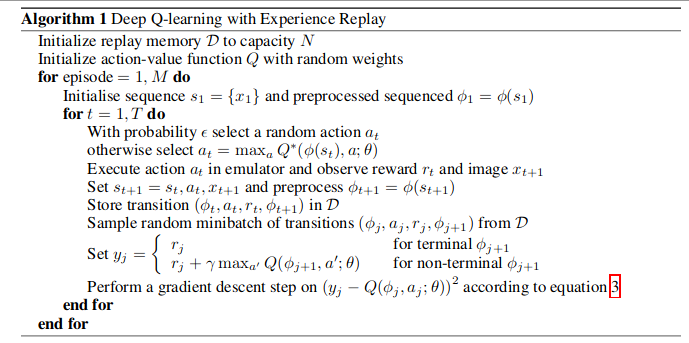

Este modelo requiere de bastante tiempo y una GPU para entrenarlo.

In [ ]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        
        print(
        "\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}\tMean Max-Q {:.5f}"
            .format(
            iteration, step, n_steps, step * 100 / n_steps, loss_val, mean_max_q),end="")

        if done: # game over, start again
            obs = env.reset()
            for skip in range(skip_start): # skip the start of each game
                obs, reward, done, info = env.step(0)
            state = preprocess_observation(obs)

        # Online DQN evaluates what to do
        # Online DQN evalua qué hacer
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)

        # Online DQN plays
        # Online DQN juega
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)

        # Guardamos en memoria lo sucedido
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state

        # Estadísticas para ver el progreso
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        if iteration < training_start or iteration % training_interval != 0:
            continue # para entrenar tras un periodo inicial y solo en intervalos regulares
        
        # Extraemos muestras de la memoria y usamos la target DQN para producir el objetivo Q-Value
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Entrenamos online DQN
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val, X_action: X_action_val, y: y_val})

        # Regularmente copiamos la online DQN a la target DQN
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # Guardamos el modelo
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

In [ ]:
#Una vez entrenado usamos esta celda para que el agente juegue.

frames = []
n_max_steps = 10000

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)

    obs = env.reset()
    for step in range(n_max_steps):
        state = preprocess_observation(obs)

        # Online DQN evalua qué hacer
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = np.argmax(q_values)

        # Online DQN juega
        obs, reward, done, info = env.step(action)

        img = env.render(mode="rgb_array")
        frames.append(img)

        if done:
            break

In [ ]:
#Esta celda se usa para mostrar el resultado del juego realizado por el agente

%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

plot_animation(frames)